In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using CUDA


In [4]:
with open("./data/text8_train.txt", "r") as f:     
    train_text = f.read() 
with open("./data/text8_test.txt", "r") as f:     
    test_text = f.read()

print(f"Training text length: {len(train_text):,} characters")
print(f"Test text length: {len(test_text):,} characters")
print(f"Sample: '{train_text[:100]}'")

Training text length: 90,000,000 characters
Test text length: 5,000,000 characters
Sample: ' anarchism originated as a term of abuse first used against early working class radicals including t'


In [5]:
chars = sorted(list(set(train_text + test_text)))
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")
print(f"Characters: {chars}")

# Create character to index and index to character mappings
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"\nchar_to_idx: {char_to_idx}")

Vocabulary size: 27
Characters: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

char_to_idx: {' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [6]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx
        
        # Create sequences
        self.data = []
        for i in range(len(text) - seq_length):
            seq = text[i:i + seq_length]
            target = text[i + seq_length]
            self.data.append((seq, target))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        seq, target = self.data[idx]
        # Convert to indices
        seq_idx = torch.tensor([self.char_to_idx[ch] for ch in seq], dtype=torch.long)
        target_idx = torch.tensor(self.char_to_idx[target], dtype=torch.long)
        return seq_idx, target_idx

In [35]:
SEQ_LENGTH = 50  # Length of input sequences (reduced from 100)
BATCH_SIZE = 512
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
LEARNING_RATE = 0.0005 # Reduced from 0.002 for more stable training
NUM_EPOCHS = 1  # Can train multiple epochs with lower LR
DROPOUT = 0.3
GRAD_CLIP = 1.0  # Stricter gradient clipping (reduced from 5.0)

USE_SUBSET = False
SUBSET_SIZE = 25_000_000  # Use 25M characters instead of full dataset

if USE_SUBSET:
    train_text_subset = train_text[:SUBSET_SIZE]
    test_text_subset = test_text[:min(SUBSET_SIZE // 10, len(test_text))]
    print(f"Using subset: {len(train_text_subset):,} train chars, {len(test_text_subset):,} test chars")
else:
    train_text_subset = train_text
    test_text_subset = test_text

In [36]:
print("Creating datasets...")
train_dataset = CharDataset(train_text_subset, SEQ_LENGTH, char_to_idx)
test_dataset = CharDataset(test_text_subset, SEQ_LENGTH, char_to_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Number of training sequences: {len(train_dataset):,}")
print(f"Number of test sequences: {len(test_dataset):,}")
print(f"Number of training batches: {len(train_loader):,}")

Creating datasets...
Number of training sequences: 89,999,950
Number of test sequences: 4,999,950
Number of training batches: 175,782


In [9]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.3):
        super(CharLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        if hidden is None:
            lstm_out, hidden = self.lstm(embedded)
        else:
            lstm_out, hidden = self.lstm(embedded, hidden)
        
        # Take the last output
        lstm_out = self.dropout(lstm_out[:, -1, :])  # (batch_size, hidden_dim)
        output = self.fc(lstm_out)  # (batch_size, vocab_size)
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)


In [37]:
model = CharLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler for adaptive learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                   patience=1, min_lr=1e-5)

# Print model summary
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# print the inital learning rate
print(f"Initial Learning Rate: {optimizer.param_groups[0]['lr']}")


CharLSTM(
  (embedding): Embedding(27, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=27, bias=True)
)

Total parameters: 931,995
Trainable parameters: 931,995
Initial Learning Rate: 0.0005


In [43]:
def train_epoch(model, train_loader, criterion, optimizer, device, iteration_losses=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    num_of_iterations_without_improvement = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping (stricter for stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP)
        
        optimizer.step()
        
        # Record iteration loss
        if iteration_losses is not None:
            iteration_losses.append(loss.item())
            
        # check if iteration loss has been decreasing
        if len(iteration_losses) > 10:
            recent_avg = sum(iteration_losses[-5:]) / 5
            prev_avg = sum(iteration_losses[-10:-5]) / 5
            if recent_avg > prev_avg:
                num_of_iterations_without_improvement += 1
        
        # break if no improvement after 10_000 iterations
        if num_of_iterations_without_improvement >= 15_000:
            print("Stopping early due to no improvement in iteration loss.")
            break
        
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [44]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
iteration_losses = []  # Track loss at every iteration
best_test_loss = float('inf')

print("Starting training...\n")
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Train (pass iteration_losses list)
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, iteration_losses)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # Learning rate scheduling based on test loss
    scheduler.step(test_loss)
 
    # Save best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_state = model.state_dict().copy()
        print(f"✓ New best model saved (test loss: {test_loss:.4f})")
    
    # Early stopping if performance is degrading significantly
    if len(test_losses) >= 2 and test_loss > test_losses[-2] * 1.5:
        print(f"\n⚠️ Warning: Test loss increased by >50%. Consider stopping or reducing learning rate.")
    
    print()

# Load best model
if 'best_model_state' in locals():
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with test loss: {best_test_loss:.4f}")

print("Training completed!")
print(f"Total iterations trained: {len(iteration_losses):,}")

Starting training...

Epoch 1/1
Current learning rate: 0.000500


Training:  17%|█▋        | 30216/175782 [26:31<2:07:47, 18.98it/s, loss=1.4359, acc=56.29%]


Stopping early due to no improvement in iteration loss.


Evaluating: 100%|██████████| 9766/9766 [03:12<00:00, 50.80it/s]

Train Loss: 0.2444, Train Acc: 56.29%
Test Loss: 1.3102, Test Acc: 59.09%
✓ New best model saved (test loss: 1.3102)

Loaded best model with test loss: 1.3102
Training completed!
Total iterations trained: 30,217


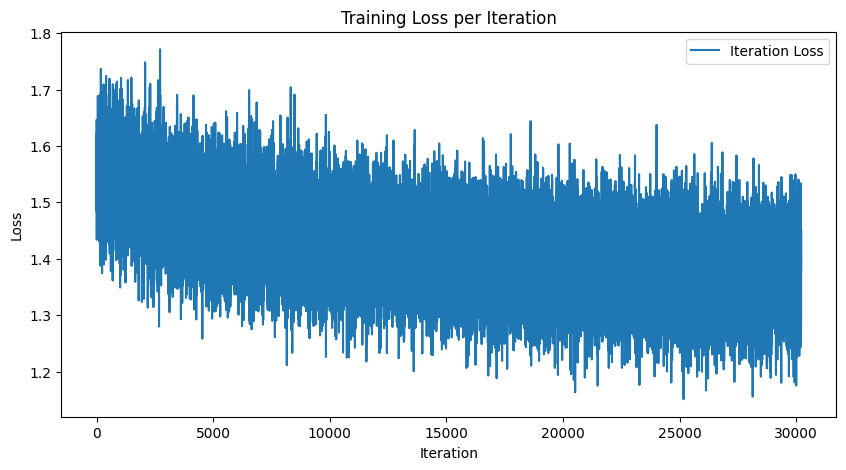

In [45]:
# plot the iteration losses
plt.figure(figsize=(10, 5))
plt.plot(iteration_losses, label='Iteration Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss per Iteration')
plt.legend()
plt.show()

In [28]:
def generate_text(model, start_string, char_to_idx, idx_to_char, device, 
                  length=500, temperature=1.0):
    """
    Generate text using the trained model
    
    Args:
        model: Trained LSTM model
        start_string: String to start generation
        char_to_idx: Character to index mapping
        idx_to_char: Index to character mapping
        device: Device to run on
        length: Number of characters to generate
        temperature: Sampling temperature (higher = more random)
    """
    model.eval()
    
    # Convert start string to indices
    input_seq = [char_to_idx.get(ch, 0) for ch in start_string.lower()]
    generated = start_string.lower()
    
    with torch.no_grad():
        for _ in range(length):
            # Prepare input
            x = torch.tensor(input_seq[-SEQ_LENGTH:], dtype=torch.long).unsqueeze(0).to(device)
            
            # Pad if necessary
            if x.size(1) < SEQ_LENGTH:
                padding = torch.zeros((1, SEQ_LENGTH - x.size(1)), dtype=torch.long).to(device)
                x = torch.cat([padding, x], dim=1)
            
            # Get prediction
            output, _ = model(x)
            output = output.squeeze()
            
            # Apply temperature
            output = output / temperature
            probs = torch.softmax(output, dim=0)
            
            # Sample from distribution
            predicted_idx = torch.multinomial(probs, 1).item()
            predicted_char = idx_to_char[predicted_idx]
            
            generated += predicted_char
            input_seq.append(predicted_idx)
    
    return generated

In [46]:
# Generate text samples with different seeds
print("=" * 80)
print("GENERATED TEXT SAMPLES")
print("=" * 80)

seeds = ["hello my fri", "the "]
temperatures = [0.5, 0.8, 1.0]

for seed in seeds:
    print(f"\n{'='*80}")
    print(f"Seed: '{seed}'")
    print(f"{'='*80}")
    
    for temp in temperatures:
        print(f"\n--- Temperature: {temp} ---")
        generated = generate_text(model, seed, char_to_idx, idx_to_char, device, 
                                 length=300, temperature=temp)
        print(generated)
        print()

GENERATED TEXT SAMPLES

Seed: 'hello my fri'

--- Temperature: 0.5 ---
hello my fride of the little was a constantinal the continued to the computer tradition of the work of the form of the one nine nine six the southern war the position of the soviet explorers with sector based on the access to the same computing the human based on the connection of the composition of the say the


--- Temperature: 0.8 ---
hello my friends one nine two nine one nine seven zero s clock the three soldiers to be an english can quest kist remarked his awarded to see prevent nature system has been vision is the country sharadomachen and conditional the edict networks minister of a many on the first interpretation of the development of


--- Temperature: 1.0 ---
hello my friets wear the duhe this form out about cackoblar color that hustanitary calend he saude campus books at the protocol of characterized real collections square master patterns over domestic was unknown as any lithuanel singer form hard last